In [ ]:
!pip install -q datasets

In [2]:
from transformers import AutoTokenizer
import torch.nn as nn
from torch.utils.data import DataLoader
import torch

# #extract pretrained tokenizer from huggingface
# tokenizer=AutoTokenizer.from_pretrained('gpt2')
# tokenizer

device='cuda' if torch.cuda.is_available() else 'cpu'

## Load the English to Nepali Translation Dataset From Huggingface

In [3]:
from datasets import load_dataset

ds = load_dataset("CohleM/english-to-nepali")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/177334 [00:00<?, ? examples/s]

In [4]:
ds['train']

Dataset({
    features: ['en', 'ne'],
    num_rows: 177334
})

## Make Train Dataloader

In [5]:

# making train dataloader
train_dataloader=DataLoader(ds['train'],batch_size=1,shuffle=False)
train_dataloader

In [6]:
# extracting a single batch from the traindataloader
for data in train_dataloader:
  print(data)
  break

{'en': ['Technical committees will be attached to each ministry.'], 'ne': ['प्रत्येक मन्त्रालय अन्तर्गत शिल्प (टेक्निकल) कमिटीहरु गठन गरिनेछन्']}


In [7]:
# dictionary for the tokenized data
t_dict={'en':[],
        'ne':[]
        }


In [8]:
# making a dictionary of tokens for both english and nepali language

# extract every sentence from the dataloader and tokenize it one by one.. not a good method. need to add padding manually by
# deriving the maximum length of tokens for each batch and after that add padding to make the same length.
# padding is needed beacuse we are making the batch. otherwise it is not needed in RNN.

# for data in train_dataloader:

#     for sentence in data['en']:
#         t_dict['en'].append(tokenizer.encode(sentence))

#     for sentence in data['ne']:
#         t_dict['ne'].append(tokenizer.encode(sentence))

#     break


In [9]:
# gpt2 doesnt have special tokens to adding a padding token and start of sentence token
# tokenizer.add_special_tokens({'pad_token':'<pad>'})
# tokenizer.add_special_tokens({'bos_token':'<sos>'})

In [10]:
# for data in train_dataloader:
#     t_dict['en']=tokenizer(data['en'],padding=True)['input_ids']
#     t_dict['ne']=tokenizer(data['ne'],padding=True)['input_ids']
#     print(t_dict['en'])
#     break

In [11]:

# # finding maximum sentence length for each batch for english langauge
# sen_length=[]
# for sen in t_dict['en']:
#     sen_length.append(len(sen))

# # add zero padding to all token if not of same length(max length)
# for sen in t_dict['en']:
#     for i in range(len(sen),max(sen_length)):
#         sen.append(0)


In [12]:
# # finding maximum sentence length
# max(sen_length)

## Building Custom Tokenizer

In [13]:
class Toke():
    def __init__(self,text,final_vocab_size):
        self.final_vocab_size=final_vocab_size
        self.tokens = text.encode("utf-8") # raw bytes
        self.tokens = list(map(int, self.tokens)) # convert to a list of integers in range 0..255 for convenience
        self.ids = list(self.tokens) # copy so we don't destroy the original list
        self.merges = {} # (int, int) -> int
        self.vocab={idx: bytes([idx]) for idx in range(256)}

    def get_stats(self,ids):
        self.counts={}
        for pair in zip(ids, ids[1:]):
            self.counts[pair] = self.counts.get(pair, 0) + 1
        return self.counts

    def merge(self,ids, pair, idx):
        i = 0
        self.newids=[]
        while i < len(ids):
            if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
                self.newids.append(idx)
                i += 2
            else:
                self.newids.append(ids[i])
                i += 1
        return self.newids

    # make the vocab reamining
    def create_final_vocab(self):

        # create the merge dictionary using BPE algo
        for i in range(self.final_vocab_size-256):
            stats = self.get_stats(self.ids)
            pair = max(stats, key=stats.get)
            idx = 256 + i
            print(f"merging {pair} into a new token {idx}")
            self.ids = self.merge(self.ids, pair, idx)
            self.merges[pair] = idx

        # create final vocab
        for (p0, p1), idx in self.merges.items():
            self.vocab[idx] = self.vocab[p0] + self.vocab[p1]


    def encode(self,text):
        # given a string, return list of integers (the tokens)
        tokens = list(text.encode("utf-8"))
        while len(tokens) >= 2:
            stats = self.get_stats(tokens)
            pair = min(stats, key=lambda p: self.merges.get(p, float("inf")))
            if pair not in self.merges:
                break # nothing else can be merged
            idx = self.merges[pair]
            tokens = self.merge(tokens, pair, idx)
        return tokens

    def decode(self,ids):
        # given ids (list of integers), return Python string
        tokens = b"".join(self.vocab[idx] for idx in ids)
        text = tokens.decode("utf-8", errors="replace")
        return text



### Use Already Trained Custom Tokenizer
  1. Load the save tokenizer from `custom_tokenizer.pt` file

In [ ]:
#Load the saved tokenizer
otoke=torch.load('/content/custom_tokenizer.pt')


# to train the tokenizer
# otoke=Toke(text="<your text here> ",final_vocab_size=1000)
# otoke.create_final_vocab()

# adding start of sentence token in vocab
otoke.vocab[1000]=b'<sos>'

## Build Encoder for Langugage Translation Task

In [14]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding=nn.Embedding(1001,128)
        self.rnn=nn.RNN(128,hidden_size=32,batch_first=True)


    def forward(self,x,hidden=None):
        x=self.embedding(x)
        x,hidden=self.rnn(x,hidden)
        return x,hidden


In [15]:
model_rnn=Encoder()
model_rnn.to(device)

Encoder(
  (embedding): Embedding(1001, 128)
  (rnn): RNN(128, 32, batch_first=True)
)

In [16]:
# enc_out,enc_hid=model_rnn(torch.tensor(otoke.encode(data['en'][0])).unsqueeze(0))

In [17]:
# enc_out.shape,enc_hid.shape

In [18]:
# torch.tensor(t_dict['en']).shape

## Build Decoder for Language Translation Task

In [19]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.embedding=nn.Embedding(1001,128)
        self.rnn=nn.RNN(128,hidden_size=32,batch_first=True)
        self.linear=nn.Linear(32,1001)


    def forward(self,encoder_outputs,encoder_hidden,target_tensor=None):

        batch_size=encoder_outputs.shape[0]
        decoder_input=torch.empty(batch_size,1,dtype=torch.long,device='cpu').fill_(torch.tensor(1000))#(torch.tensor(tokenizer.encode(tokenizer.bos_token)[0]))
        decoder_hidden=encoder_hidden
        decoder_outputs=[]

        for i in range(target_tensor.shape[1]):
        # for i in range(5):
            decoder_out,decoder_hidden=self.forward_step(decoder_input,decoder_hidden)
            decoder_outputs.append(decoder_out)

            if target_tensor is not None:
                decoder_input=target_tensor[:,i].unsqueeze(1)
            else:
                _, topi = decoder_out.topk(1)
                decoder_input = topi.squeeze(-1).detach()


        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = nn.functional.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden

    def forward_step(self,input,hidden):
        out=self.embedding(input)
        out,hidden=self.rnn(out,hidden)
        out=self.linear(out)
        return out,hidden



In [20]:
dec_rnn=Decoder()
dec_rnn.to(device)

Decoder(
  (embedding): Embedding(1001, 128)
  (rnn): RNN(128, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=1001, bias=True)
)

In [21]:
# dec_out,dec_hidden=dec_rnn(encoder_outputs=enc_out.to(device),encoder_hidden=enc_hid.to(device),target_tensor=torch.tensor(t_dict['ne']).to(device))
# dec_out.shape,dec_hidden.shape


In [22]:
# outty=dec_out.argmax(dim=-1)
# outty.shape

In [23]:
# tokenizer.decode(outty[3])

In [24]:
# len(train_dataloader)

## Train the Language Translation Model

In [25]:
# model_rnn=torch.load('/content/Lencoder.pt',map_location=torch.device(device))
# dec_rnn=torch.load('/content/Ldecoder.pt',map_location=torch.device(device))

# optimizers for encoder and decoder
encoder_optimizer=torch.optim.Adam(model_rnn.parameters(),lr=0.01)
decoder_optimizer=torch.optim.Adam(dec_rnn.parameters(),lr=0.01)

# loss function
criterion=nn.NLLLoss()

In [30]:
train_loss=[]

In [31]:
for epoch in range(10):
  total_loss = 0
  num_example=0
  for data in train_dataloader:

      num_example+=1
      # t_dict['en']=tokenizer(data['en'],padding=True)['input_ids']
      # t_dict['ne']=tokenizer(data['ne'],padding=True)['input_ids']

      t_dict['en']=torch.tensor(otoke.encode(data['en'][0])).unsqueeze(0)
      t_dict['ne']=torch.tensor(otoke.encode(data['ne'][0])).unsqueeze(0)

      encoder_optimizer.zero_grad()
      decoder_optimizer.zero_grad()

      enc_out,enc_hid=model_rnn((t_dict['en']).to(device))
      dec_out,dec_hidden=dec_rnn(encoder_outputs=enc_out,encoder_hidden=enc_hid,target_tensor=(t_dict['ne']).to(device))

      loss = criterion(
          dec_out.view(-1, dec_out.size(-1)),
          torch.tensor(t_dict['ne']).to(device).view(-1)
      )
      loss.backward()

      encoder_optimizer.step()
      decoder_optimizer.step()

      total_loss += loss.item()
      # print the output if
      if(loss.item()<0.1):
        print(f"\nEnglish: {otoke.decode((t_dict['en']).squeeze(0).tolist())}")
        print(f"True: {otoke.decode((t_dict['ne']).squeeze(0).tolist())}")
        print(f"Predicted: {otoke.decode(dec_out.argmax(dim=-1).squeeze(0).tolist())}")

      if num_example>500:
        break
  train_loss.append(total_loss/num_example)
  print(f"Epoch: {epoch+1}  Loss: {total_loss/num_example}")


<ipython-input-31-a1f8e2165bf7>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(t_dict['ne']).to(device).view(-1)


Epoch: 1  Loss: 3.965937385540047
Epoch: 2  Loss: 3.7632058399642063
Epoch: 3  Loss: 3.6739751914304173
Epoch: 4  Loss: 3.6475664339141693
Epoch: 5  Loss: 3.6185693797950975
Epoch: 6  Loss: 3.6144835408814178
Epoch: 7  Loss: 3.590951623554953
Epoch: 8  Loss: 3.582681463864035
Epoch: 9  Loss: 3.577854411806651
Epoch: 10  Loss: 3.5587097439699305


In [31]:
dec_out.shape

torch.Size([1, 48, 1001])

## Loss Curves

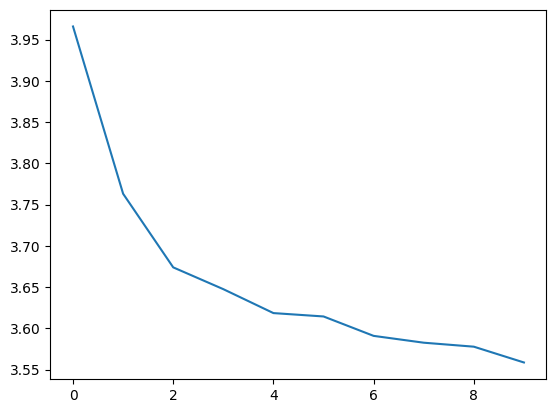

In [32]:
import matplotlib.pyplot as plt

plt.plot(train_loss)

In [33]:
otoke.decode(dec_out.argmax(dim=-1).squeeze(0).tolist())

'यसम्बन्धी�ाग�स�सार बमा � अ्यकेछुख्याको �मा �  स स२ृद्धिमा � सर समा �ेहीी सको छ्यनि सेही�ेषदमा �नि स विकासका �हरूहरू गर्नप सन्�ख्येशरि अेही उपल�ृद्धि�दफेछिन्छभ स ेही�बाटमा � जेही�ेषद अई उपल�मा �हरू २ृद्धिमा � सर स'

In [33]:
# torch.save(model_rnn.state_dict(),'Ld_encoder.pt')
# torch.save(dec_rnn.state_dict(),'Ld_decoder.pt')

In [34]:
torch.save(model_rnn,'Lencoder.pt')
torch.save(dec_rnn,'Ldecoder.pt')

In [34]:

t_dict['en']=torch.tensor(otoke.encode('The country should look over its citizens')).unsqueeze(0)
t_dict['ne']=torch.tensor(otoke.encode('देशले आफ्ना नागरिकलाई हेर्नुपर्छ')).unsqueeze(0)

enc_out,enc_hid=model_rnn((t_dict['en']).to(device))
dec_out,dec_hidden=dec_rnn(encoder_outputs=enc_out,encoder_hidden=enc_hid,target_tensor=(t_dict['ne']).to(device))


In [35]:
otoke.decode(dec_out.argmax(dim=-1).squeeze(0).tolist())

'देशमा � गर्दगेरमा �ज्नेस विकास अोको छु प्र�'